In [1]:
# CONVERSION PERFORMS THE ACTUAL VOICE CONVERSION THAT HAPPENS AFTER A MODEL IS TRAINED
import os
import pickle
import torch
import numpy as np
from math import ceil
from model_vc import Generator
import matplotlib.pyplot as plt

def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

In [2]:
# SET UP VARIABLES

torch.backends.cudnn.benchmark = True
cuda_num = 1
device = f'cuda:{cuda_num}'
num_trained_spkrs = 20
freq = 32
bottle_neck = 32
dim_pitch = 257
one_hot = True
ckpt_iters = 700000
example_name = '001'
spec_dir = './spmel'
root = './model_data'
model_name = '1Hot16FreqFrom400kIters'
model_path = root +'/' +model_name
checkpoint_path = model_path +'/ckpts/ckpt_' +str(ckpt_iters) +'.pth.tar'

In [3]:
print(checkpoint_path)
print('./model_data/1Hot16FreqFrom400kIters/ckpts/ckpt_700000.pth.tar')

./model_data/1Hot16FreqFrom400kIters/ckpts/ckpt_700000.pth.tar
./model_data/1Hot16FreqFrom400kIters/ckpts/ckpt_700000.pth.tar


In [4]:
# PREPARE THE MODEL

if one_hot==True:
    G = Generator(bottle_neck, num_trained_spkrs, dim_pitch, 512, freq)
else:
    G = Generator(bottle_neck, 256, dim_pitch, 512, freq)

# pretrained autovc model loaded into G model
g_optimizer = torch.optim.Adam(G.parameters(), 0.0001)
g_checkpoint = torch.load(checkpoint_path)
G.load_state_dict(g_checkpoint['model_state_dict'])
g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dict'])

for state in g_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda(cuda_num)

G.to(device)
G.eval()
print('model loaded')

model loaded


In [5]:
# VIEW SPEAKERS IN EACH OF DATA
training_meta_data = pickle.load(open(root +'/' +model_name +'/training_meta_data.pkl', "rb"))
all_meta_data = pickle.load(open('all_meta_data.pkl', "rb"))

for i, spkr_i in enumerate(training_meta_data):
    print('Training speaker: ', spkr_i[0])

# ESTABLISH A TEST SET OF SPEAKERS

# p360  19  M    American  New  Jersey
# p259  23  M    English    Nottingham
# p233  23  F    English    Staffordshire
# p228  22  F    English    Southern  England

test_speakers = ['p360', 'p259', 'p233', 'p228']
if one_hot==True:
    test_speaker_idx = []
    for i, spkr_i in enumerate(test_speakers):
        for j, spkr_j in enumerate(training_meta_data):
            if spkr_i == spkr_j[0]:
                #print(j, spkr_i)
                test_speaker_idx.append(j)

# MAKE ONE-HOT ARRAYS
num_training_spkrs = len(training_meta_data)
if one_hot==True:
    one_hot_array = np.eye(num_training_spkrs)[np.arange(num_training_spkrs)]

test_spkr_embs = []
if one_hot==True:
    for spkr_idx in test_speaker_idx:
        spkr_emb = one_hot_array[spkr_idx]
        test_spkr_embs.append(spkr_emb)
else:
    for spkr_id_i in test_speakers:
        for spkr_data in all_meta_data:
            if spkr_id_i == spkr_data[0]:
                spkr_emb = spkr_data[1]
                test_spkr_embs.append(spkr_emb)

Training speaker:  p244
Training speaker:  p303
Training speaker:  p376
Training speaker:  p360
Training speaker:  p341
Training speaker:  p233
Training speaker:  p259
Training speaker:  p241
Training speaker:  p293
Training speaker:  p284
Training speaker:  p287
Training speaker:  p315
Training speaker:  p275
Training speaker:  p347
Training speaker:  p253
Training speaker:  p238
Training speaker:  p292
Training speaker:  p228
Training speaker:  p364
Training speaker:  p276


In [7]:
# collect paths for audio files and collect specs
test_spkr_specs = []
database_paths = []
database_root = '/import/c4dm-datasets/VCTK-Corpus-0.92/wav48_silence_trimmed'
for spkr in test_speakers:
    spec_path = spec_dir +'/' +str(spkr) +'/' +str(spkr) +'_' +example_name +'_mic1.npy'
    audio_path = database_root +'/' +str(spkr) +'/' +str(spkr) +'_' +example_name +'_mic1.flac'
    #print(spkr, spec_path)
    database_paths.append(audio_path)
    spec = np.load(spec_path)
    test_spkr_specs.append(spec)

# Use specific tensors copied from training

In [8]:
"""Steal input values from same saved tensors used to train the NN with near-perfect reconstruction"""
spkr_ids = '_p253p292.pt'
image_comp_path = 'model_data/1Hot16FreqFrom700kIters/image_comparison/'

batch_mel = torch.load(image_comp_path +'mel_batch' +spkr_ids)
print('batch_mel',batch_mel.shape)

batch_emb_org = torch.load(image_comp_path +'emb_org' +spkr_ids)
print('batch_emb_org',batch_emb_org.shape)

batch_pitch = torch.load(image_comp_path +'pitch' +spkr_ids)
print('batch_pitch',batch_pitch.shape)

x_identic_psnt_from_training = torch.load(image_comp_path +'x_identic_psnt' +spkr_ids)

print(type(batch_mel), batch_mel.shape, batch_mel)
print(type(batch_pitch), batch_pitch.shape, batch_pitch)
print(type(batch_emb_org), batch_emb_org.shape, batch_emb_org)

"""They all match up, and basically ARE the same tensors used in training"""

batch_mel torch.Size([2, 128, 80])
batch_emb_org torch.Size([2, 20])
batch_pitch torch.Size([2, 128, 257])
<class 'torch.Tensor'> torch.Size([2, 128, 80]) tensor([[[0.3832, 0.2331, 0.2054,  ..., 0.0000, 0.0000, 0.0000],
         [0.3824, 0.2550, 0.2289,  ..., 0.0000, 0.0000, 0.0000],
         [0.3756, 0.2473, 0.2626,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.4561, 0.6622, 0.7775,  ..., 0.4936, 0.4522, 0.4434],
         [0.4617, 0.5996, 0.6407,  ..., 0.5436, 0.5152, 0.4822],
         [0.3789, 0.4149, 0.4474,  ..., 0.5641, 0.5340, 0.4979]],

        [[0.3407, 0.2235, 0.2330,  ..., 0.0651, 0.1084, 0.0878],
         [0.3329, 0.2248, 0.1865,  ..., 0.0662, 0.0885, 0.0937],
         [0.3347, 0.2320, 0.2003,  ..., 0.0948, 0.0752, 0.0709],
         ...,
         [0.2928, 0.2668, 0.2534,  ..., 0.1539, 0.1284, 0.1076],
         [0.3204, 0.3198, 0.2104,  ..., 0.1489, 0.1291, 0.1054],
         [0.3535, 0.3315, 0.2916,  ..., 0.1259, 0.1290, 0.1050]]],
       device='cuda:1')
<class 't

'They all match up, and basically ARE the same tensors used in training'

In [9]:
mel1 = batch_mel[0].unsqueeze(0)
mel2 = batch_mel[1].unsqueeze(0)
pitch1 = batch_pitch[0].unsqueeze(0)
pitch2 = batch_pitch[1].unsqueeze(0)
emb_org1 = batch_emb_org[0].unsqueeze(0)
emb_org2 = batch_emb_org[1].unsqueeze(0)

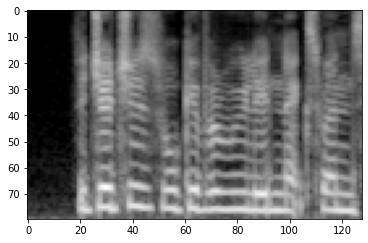

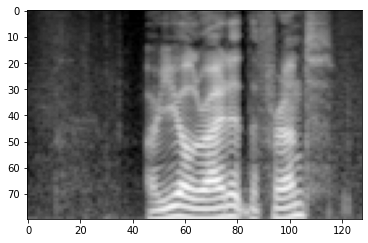

In [10]:
# Presenting these tensors as melspecs
batch_mel_squeezed = batch_mel.squeeze(1).cpu().data.numpy()
for mels in batch_mel_squeezed:
    mels = np.rot90(mels)
    plt.imshow(mels, cmap='gray')
    plt.show()

conversion done


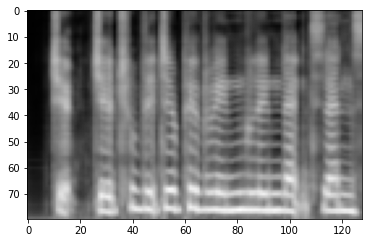

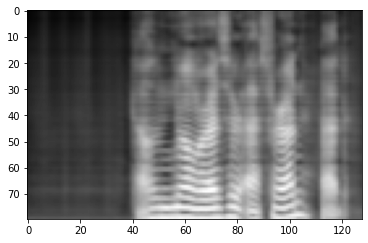

In [11]:
# as this is conversion not training, no backprop/gradientCommunication needed here
_, x_identic_psnt, _ = G(batch_mel, batch_emb_org, batch_emb_org, batch_pitch, batch_pitch)

uttr_trg = x_identic_psnt.squeeze(1).detach().cpu().numpy()

print('conversion done')
for mels in uttr_trg:
    mels = np.rot90(mels)
    plt.imshow(mels, cmap='gray')
    plt.show()

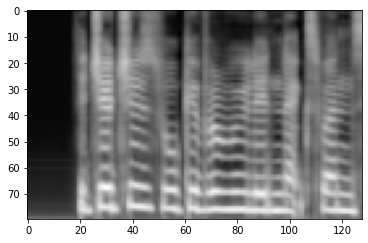

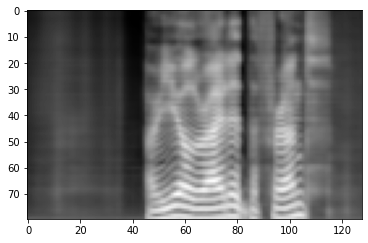

In [13]:
# HERE IS THE GENERATED SPEC TO ONE TAKEN FROM TRAINING SESSION

x_identic_psnt_from_training = x_identic_psnt_from_training.squeeze(1).detach().cpu().numpy()

for mels in x_identic_psnt_from_training:
    mels = np.rot90(mels)
    plt.imshow(mels, cmap='gray')
    plt.show()

# Generate examples from the original test list

In [14]:
# make format that can be fed to converter which consists of a list of id, spkr_emb, mel_spec
training_data_for_synthesis = []

for i in range(len(test_speakers)):
    spkr_tuple = (test_speakers[i], test_spkr_embs[i], test_spkr_specs[i])
#     print(spkr_tuple)
    training_data_for_synthesis.append(spkr_tuple)

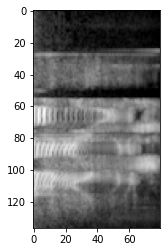

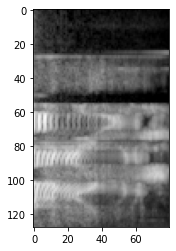

inputs for tensor finalised


In [38]:
"""Generate own input values"""

mel = np.load('./spmel/p360/p360_001_mic1.npy')

org_name = training_data_for_synthesis[0][0]
org_emb = training_data_for_synthesis[0][1]
trg_name = training_data_for_synthesis[2][0]
trg_emb = training_data_for_synthesis[2][1]

org_1hot_pitch = pickle.load(open('./pitch/' +org_name +'/' +org_name +'_' +example_name +'_mic1.pkl', 'rb'))[0]
trg_1hot_pitch = pickle.load(open('./pitch/' +trg_name +'/' +trg_name +'_' +example_name +'_mic1.pkl', 'rb'))[0]

plt.imshow(mel, cmap='gray')
plt.show()

# org_1hot_pitch, _ = pad_seq(org_1hot_pitch)
org_1hot_pitch = org_1hot_pitch[:128]
org_1hot_pitch = np.expand_dims(org_1hot_pitch, 0)
org_1hot_pitch = torch.from_numpy(org_1hot_pitch).to(device).float()

#x_org = mel
#x_org, len_pad = pad_seq(x_org)

x_org = mel[:128]

# utterance origin is just padded spec in tensor form
uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device).float()
# speaker embedding 
emb_org = torch.from_numpy(org_emb[np.newaxis, :]).to(device).float()

uttr_trans = torch.Tensor.cpu(uttr_org).detach().numpy()[-1,:,:]
plt.imshow(uttr_trans, cmap='gray')
plt.show()

trg_1hot_pitch, _ = pad_seq(trg_1hot_pitch)
trg_1hot_pitch = np.expand_dims(trg_1hot_pitch, 0)
trg_1hot_pitch = torch.from_numpy(trg_1hot_pitch).to(device).float()
# embedding target represents S2 in the paper - the embedding provided by a pretrained Speaker Encoder
# I guess this converts each utterance from the data so that it matches the utterance of every speaker
# So if there were 4 utterances with different speakers, then this code will generate 4*4=16 conversions
emb_trg = torch.from_numpy(trg_emb[np.newaxis, :]).to(device)

nn_inputs = [uttr_org, emb_org, org_1hot_pitch]

print('inputs for tensor finalised')

conversion done


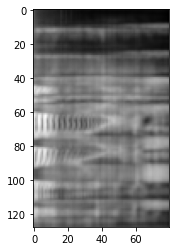

In [39]:
# as this is conversion not training, no backprop/gradientCommunication needed here
with torch.no_grad():
    
    _, x_identic_psnt, _ = G(uttr_org,
                             emb_org,
                             emb_org,
                             org_1hot_pitch,
                             org_1hot_pitch)
uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()

print('conversion done')

plt.imshow(uttr_trg, cmap='gray')
plt.show()

In [44]:
# prepare wavenet operations

import torch
import librosa
import soundfile as sf
import pickle
from synthesis import build_model
from synthesis import wavegen


device = torch.device("cuda:0")
model = build_model().to(device)
checkpoint = torch.load("checkpoint_step001000000_ema.pth")
model.load_state_dict(checkpoint["state_dict"])

# subdir_for_conversion = subdir_for_wavs +'/conversions'
# if os.path.exists(subdir_for_conversion)==False:
#     os.makedirs(subdir_for_conversion)

waveform = wavegen(model, c=uttr_trg)   
#     librosa.output.write_wav(name+'.wav', waveform, sr=16000)
sf.write('./converted360reconstruction.wav', waveform, samplerate=16000)

waveform = wavegen(model, c=mel)   
#     librosa.output.write_wav(name+'.wav', waveform, sr=16000)
sf.write('./original360reconstruction.wav', waveform, samplerate=16000)

100%|██████████| 35072/35072 [08:53<00:00, 65.68it/s]


In [ ]:
# make format that can be fed to converter which consists of a list of id, spkr_emb, mel_spec
training_data_for_synthesis = []

for i in range(len(test_speakers)):
    spkr_tuple = (test_speakers[i], test_spkr_embs[i], test_spkr_specs[i])
    print(spkr_tuple)
    training_data_for_synthesis.append(spkr_tuple)

In [ ]:
# spect_vc collects spectrogram information to be used later for spec2wav conversion via wavnet model
from model_vc import Generator

spect_vc = []

x_org_list = []

# each sbmt_i has a speaker ID, a speaker embedding, and a spectrogram
for sbmt_i in training_data_for_synthesis:
    
    org_spkr_id = sbmt_i[0]
    org_name = './pitch/' +org_spkr_id +'/' +org_spkr_id +'_' +example_name +'_mic1.pkl'
    print()
    org_meta_pitch = pickle.load(open(org_name,'rb'))
    org_1hot_pitch = org_meta_pitch[0]
    org_1hot_pitch, _ = pad_seq(org_1hot_pitch)
    org_1hot_pitch = np.expand_dims(org_1hot_pitch, 0)
    org_1hot_pitch = torch.from_numpy(org_1hot_pitch).to(device).float()
    # x origin - 80Mel spectrogram
    x_org = sbmt_i[2]
    x_org_list.append( ('{}'.format(sbmt_i[0]), x_org) )
    x_org, len_pad = pad_seq(x_org)
    # utterance origin is just padded spec in tensor form
    uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
    # speaker embedding 
    emb_org = torch.from_numpy(sbmt_i[1][np.newaxis, :]).to(device)

    # for each entry in training_data_for_synthesis, use it as the embedding target and use this in G
    for sbmt_j in training_data_for_synthesis:
        trg_name = sbmt_j[0]
        trg_meta_pitch = pickle.load(open('./pitch/' +trg_name +'/' +trg_name +'_' +example_name +'_mic1.pkl','rb'))
        trg_1hot_pitch = trg_meta_pitch[0]
        trg_1hot_pitch, _ = pad_seq(trg_1hot_pitch)
        trg_1hot_pitch = np.expand_dims(trg_1hot_pitch, 0)
        trg_1hot_pitch = torch.from_numpy(trg_1hot_pitch).to(device).float()
        # embedding target represents S2 in the paper - the embedding provided by a pretrained Speaker Encoder
        # I guess this converts each utterance from the data so that it matches the utterance of every speaker
        # So if there were 4 utterances with different speakers, then this code will generate 4*4=16 conversions
        emb_trg = torch.from_numpy(sbmt_j[1][np.newaxis, :]).to(device)
        
        # as this is conversion not training, no backprop/gradientCommunication needed here
        with torch.no_grad():
            # x_identic_psnt = target utterance, produced by the Generator
            # Generator is fed an utterance and speaker 
            if one_hot == True:
                emb_org =emb_org.float()
                emb_trg =emb_trg.float() 
            print('org_name', org_name, 'target_spkr', trg_name)
            _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg, org_1hot_pitch, trg_1hot_pitch)
            
        if len_pad == 0:
            # utterance target is the converted speech
            uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
        else:
            uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
        # utterance is saved in a list, along with source and target ID
        spect_vc.append( ('{}x{}'.format(sbmt_i[0], sbmt_j[0]), uttr_trg) )
        
        
with open('results.pkl', 'wb') as handle:
    pickle.dump(spect_vc, handle)

with open('x_org.pkl', 'wb') as howdy:
    pickle.dump(x_org_list, howdy)

print('done')

In [ ]:
# reproduce original data from pre-compuuted (noise-injected) spectrograms

results = pickle.load(open('results.pkl', 'rb'))
subdir_for_conversion = subdir_for_wavs +'/conversions'
if os.path.exists(subdir_for_conversion)==False:
    os.makedirs(subdir_for_conversion)

for result in results:
    name = result[0]
    print(type(c))
    print(c.shape)
    c = result[1]
    print(name)
    waveform = wavegen(model, c=c)   
#     librosa.output.write_wav(name+'.wav', waveform, sr=16000)
    sf.write(subdir_for_conversion +'/' +name +'.wav', waveform, samplerate=16000)